# Hashtags
#### Jan 1, 2021

## 1.Fetch data

In [1]:
import sqlalchemy
import configparser

# DB connection parameters
config = configparser.ConfigParser()
config.read('../db_config_final.ini')

host = config.get('database', 'host')
user = config.get('database', 'user')
passwd = config.get('database', 'passwd')


engine = sqlalchemy.create_engine('postgres://{0}:{1}@{2}:5432/{0}'.format(user, passwd, host, user))
meta = sqlalchemy.MetaData()
meta.reflect(bind=engine)

In [2]:
import pandas as pd

athletes_table = sqlalchemy.Table('athletes', meta, autoload=True)
q = athletes_table.select() # select query

dfa = pd.read_sql(q, engine)

In [3]:
posts_table = sqlalchemy.Table('posts', meta, autoload=True)
q = posts_table.select() # select query

dfp = pd.read_sql(q, engine)

### Merge and select relevant columns

In [4]:
df = dfa.merge(dfp, how='right', left_on='id', right_on='author')[['gender', 'performance_075xsigma', 'hashtags']]

In [5]:
df.head()

gender performance_075xsigma  \
0      m                 under   
1      f                  over   
2      f                  over   
3      f                 under   
4      f                normal   

                                            hashtags  
0                                                 []  
1  [#makeyourdayahappyday, #bandofheroes, #uvexsp...  
2                                                 []  
3                      [#onemorerace, #allornothing]  
4                                                 []

## 2. Basic exploration


In [6]:
df['n_hashtags'] = df.hashtags.apply(len)

In [7]:
print('Average number of hashtags per post:\n', df.groupby(['gender'])['n_hashtags'].mean())

Average number of hashtags per post:
 gender
f    5.054054
m    3.622222
Name: n_hashtags, dtype: float64


In [8]:
print('Average number of hashtags per post:\n', df.groupby(['gender', 'performance_075xsigma'])['n_hashtags'].mean())

Average number of hashtags per post:
 gender  performance_075xsigma
f       normal                   3.600000
        over                     5.687500
        under                    7.000000
m       normal                   4.166667
        over                     3.866667
        under                    2.500000
Name: n_hashtags, dtype: float64


In [9]:
print('Std of number of hashtags per post:\n', df.groupby(['gender', 'performance_075xsigma'])['n_hashtags'].std())

Std of number of hashtags per post:
 gender  performance_075xsigma
f       normal                   4.563833
        over                     8.435787
        under                    7.974961
m       normal                   4.133792
        over                     3.067495
        under                    3.000000
Name: n_hashtags, dtype: float64


In [10]:
df_expl = df.explode('hashtags').dropna().reset_index(drop=True).drop(columns=['n_hashtags'], axis=1)

In [11]:
df_expl['hashtags'] = df_expl.hashtags.str.lower()

In [12]:
h_frequency = df_expl.groupby(['gender', 'performance_075xsigma','hashtags'])['hashtags'].count().reset_index(name='count')

In [13]:
h_frequency.sort_values('count', ascending=False).head()

gender performance_075xsigma             hashtags  count
48       f                  over             #are2019      4
195      m                normal         #weareskiing      4
2        f                normal      #anotherbestday      3
40       f                normal  #traiettorieliquide      3
6        f                normal        #bandofheroes      3

## 3. Wordcloud


In [14]:
import wordcloud as wc
import matplotlib.pyplot as plt

In [15]:
h_freq_all = df_expl.groupby('hashtags')['hashtags'].count().reset_index(name='count')
h_frequency_dict = dict(zip(h_freq_all.hashtags, h_freq_all['count']))

In [24]:
wordcloud = wc.WordCloud(width = 3200, height = 1600, scale = 1, background_color ='white', min_font_size = 10).generate_from_frequencies(h_frequency_dict) 

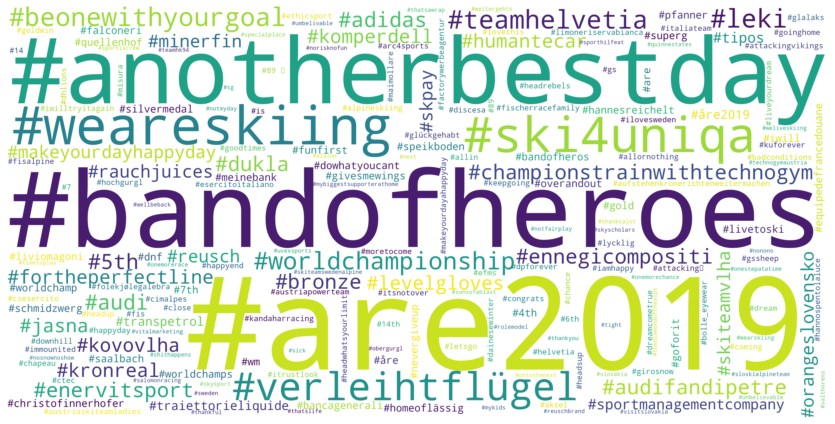

In [25]:
plt.figure(figsize=(12,6))
plt.axis('off')
plt.tight_layout()
plt.imshow(wordcloud, interpolation='bilinear');
plt.savefig('wc.png', format='png')

## 4. Conclusions

- f group uses, on average, more hashtags
- post category with most hashtags is underperformance for women, typical performance for men
- std is so large we should avoid drawing conclusions
- [NOT SHOWN HERE] the bar chart per category/gender is not particularly informative (a lot of sponsor-related hashtags)
- wordcloud is pretty, but, again, not particularly informative